In [14]:
import platform
from pathlib import Path

BIN_MAPS = {"Darwin": "mac", "Linux": "linux"}

try:
    import google.colab

    ! pip install pandas scikit-learn scikit-image requests
    ! [[ -d image-crop-analysis ]] || git clone https://github.com/twitter-research/image-crop-analysis.git
    ! [[ -d stylegan2-ada ]] || git clone https://github.com/NVlabs/stylegan2-ada.git
    ! [[ -d pytorch_deepgaze ]] || git clone https://github.com/matthias-k/DeepGaze.git
    ! [[ -d stylegan2-ffhq-config-f.pkl ]] || wget http://d36zk2xti64re0.cloudfront.net/stylegan2/networks/stylegan2-ffhq-config-f.pkl

    EXT_DIR = Path(".")
    DATA_DIR = Path(".")

except ImportError:
    import warnings
    warnings.warn("The notebook was only tested using Google's Colab.")
    
!mkdir -p .tmp

Cloning into 'DeepGaze'...
remote: Enumerating objects: 56, done.
remote: Counting objects: 100% (56/56), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 56 (delta 28), reused 50 (delta 22), pack-reused 0
Unpacking objects: 100% (56/56), done.
--2021-08-11 13:10:23--  http://d36zk2xti64re0.cloudfront.net/stylegan2/networks/stylegan2-ffhq-config-f.pkl
Resolving d36zk2xti64re0.cloudfront.net (d36zk2xti64re0.cloudfront.net)... 54.240.168.111, 54.240.168.39, 54.240.168.144, ...
Connecting to d36zk2xti64re0.cloudfront.net (d36zk2xti64re0.cloudfront.net)|54.240.168.111|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 381673535 (364M) [application/x-www-form-urlencoded]
Saving to: ‘stylegan2-ffhq-config-f.pkl.1’

stylegan2-ffhq-conf 100%[===================>] 363.99M   232MB/s    in 1.6s    

2021-08-11 13:10:25 (232 MB/s) - ‘stylegan2-ffhq-config-f.pkl.1’ saved [381673535/381673535]



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [15]:
CROP_BASE = EXT_DIR / Path("image-crop-analysis")
CROP_BIN_PATH = CROP_BASE / "bin" / BIN_MAPS[platform.system()] / "candidate_crops"
CROP_MODEL_PATH = CROP_BASE / "bin/fastgaze.vxm"
DEEPGAZE_PATH = EXT_DIR / Path("pytorch_deepgaze")
STYLEGAN_PATH = EXT_DIR / Path("stylegan2-ada")
TMP_DIR = Path(".tmp")

In [16]:
import os
import sys
sys.path.append(str(EXT_DIR / "image-crop-analysis/src"))
sys.path.append(str(DEEPGAZE_PATH))
sys.path.append(str(STYLEGAN_PATH))

In [17]:
%tensorflow_version 1.x
import re
import random
import imageio
import tempfile
import itertools
import collections

import torch
import seaborn as sns
import numpy as np
import pandas as pd

from dataclasses import dataclass
from joblib import Parallel, delayed
from IPython.display import display
from PIL import Image, ImageDraw
from scipy.misc import face
from scipy.ndimage import zoom
from scipy.special import logsumexp
from scipy.special import expit
from matplotlib import pyplot as plt

from crop_api import ImageSaliencyModel, is_symmetric, parse_output, reservoir_sampling
from image_manipulation import join_images, process_image

# StyleGAN
import pickle
import dnnlib
import dnnlib.tflib as tflib
from io import BytesIO
from math import ceil
import imageio

Load StyleGAN-2 for generating images of faces.

In [18]:
dnnlib.tflib.init_tf()
network_pkl = 'stylegan2-ffhq-config-f.pkl'
 
print('Loading networks from "%s"...' % network_pkl)
with dnnlib.util.open_url(network_pkl) as fp:
    _G, _D, Gs = pickle.load(fp)
noise_vars = [var for name, var in Gs.components.synthesis.vars.items() if name.startswith('noise')]

Loading networks from "stylegan2-ffhq-config-f.pkl"...


Utilities for using StyleGAN. 

In [19]:
# Based on https://colab.research.google.com/github/Hephyrius/Stylegan2-Ada-Google-Colab-Starter-Notebook/blob/main/Stylegan2_Ada_Colab_Starter.ipynb
def generate_zs_from_seeds(seeds):
    zs = []
    for seed_idx, seed in enumerate(seeds):
        rnd = np.random.RandomState(seed)
        z = rnd.randn(1, *Gs.input_shape[1:]) # [minibatch, component]
        zs.append(z)
    return zs

def generate_images(zs, truncation_psi, as_array=False):
    Gs_kwargs = dnnlib.EasyDict()
    Gs_kwargs.output_transform = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
    Gs_kwargs.randomize_noise = False
    if not isinstance(truncation_psi, list):
        truncation_psi = [truncation_psi] * len(zs)
        
    imgs = []
    for z_idx, z in enumerate(zs):
        Gs_kwargs.truncation_psi = truncation_psi[z_idx]
        noise_rnd = np.random.RandomState(1) # fix noise
        tflib.set_vars({var: noise_rnd.randn(*var.shape.as_list()) for var in noise_vars}) # [height, width]
        images = Gs.run(z, None, **Gs_kwargs) # [minibatch, height, width, channel]
        imgs.append(Image.fromarray(images[0], 'RGB') if as_array else images[0])
    return imgs

To select the test images, I generate a bunch of faces, and manually pick some in order to have images of people with diverse attributes. By diverse I do not only mean the classical sense considered in fairness literature such as race and gender presentation, but also things like glasses, hairstyle and hair color.

Ironically, by randomly sampling from the StyleGAN-2 model, it is extremely rare that we get images appearing as (a) elderly people, and (b) black men. Yet, biases of the StyleGAN-2 model is out of scope for now...



0


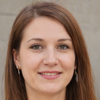

1


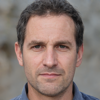

2


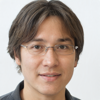

3


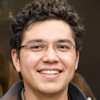

4


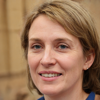

In [20]:
seed_range = (0, 5)
for i in range(*seed_range):
  print(i)
  z = generate_zs_from_seeds([i])[0]
  display(Image.fromarray(generate_images([z], truncation_psi=0.5)[0], "RGB").resize((100, 100)))

Initialize the Twitter saliency model.

In [21]:
twitter_saliency_model = ImageSaliencyModel(
    crop_binary_path=CROP_BIN_PATH,
    crop_model_path=CROP_MODEL_PATH,
)

def get_twitter_max_saliency(imagearray):
    with tempfile.NamedTemporaryFile("w+b", dir=TMP_DIR) as fp:
        Image.fromarray(imagearray).save(fp, "JPEG")
        salient_points = np.array(twitter_saliency_model.get_output(Path(fp.name))["all_salient_points"])
        return salient_points[:, 2].max()

The random search algorithm, described in the README.

In [ ]:
def get_saliency_scores(zs):
  image_arrays = generate_images(zs, truncation_psi=0.5, as_array=False)
  scores = []
  for image_array in image_arrays:
    max_saliency = get_twitter_max_saliency(image_array)
    scores.append(max_saliency)
  return np.array(scores), image_arrays

def random_search(
    init_z,              # Initial latent space vector.
    beam_size=10,        # Number of candidate modifications per iteration.
    delta=0.1,           # Noise parameter for sampled modifications.
    num_steps=10,        # Number of iterations.
    seed=0,              # Seed for sampling modifications.
    verbose=True,        # Whether to show intermediate results.
    track_history=True   # Whether to return the intermediate results.
):
  num_dims = Gs.input_shape[1:][0]

  current_z = init_z
  scores, image_arrays = get_saliency_scores([current_z])
  best_index = 0
  if track_history:
    history = []
  prng = np.random.RandomState(seed)

  for t in range(num_steps):
    best_image = Image.fromarray(image_arrays[best_index], "RGB")
    history.append((scores[best_index], best_image))
    if verbose:
      print("step:", t, "/ score:", scores.max())
      display(best_image.resize((100, 100)))

    zs = [current_z]
    for i in range(beam_size):
      zs.append(current_z + prng.multivariate_normal(
          [0] * num_dims, delta * np.eye(num_dims)))

    scores, image_arrays = get_saliency_scores(zs)
    best_index = scores.argmax()
    current_z = zs[best_index]
  if verbose:
    print("step:", t, "/ score:", scores.max())
  final_image = generate_images([current_z], truncation_psi=0.5)[0]
  history.append((scores[best_index], final_image))
  return (final_image, history) if track_history else final_image

## The closest thing to a "unit test".
# init_z = generate_zs_from_seeds([116])[0]
# image, history = random_search(
#     init_z, delta=0.02, beam_size=2, num_steps=3, seed=1)
# print(len(history))
# display(Image.fromarray(np.hstack([history[0][1], image]), "RGB").resize((200, 100)))

In [13]:
seeds_data = {}

In [ ]:
seeds = [
  155,
  162,
  154,
  116,
  491,
  489,
  492,
  355,
  356,
  372,
  387,
  388,
  450,
  374,
  368,
  1407
]
search_params = dict(
  delta=0.04, beam_size=20, num_steps=5, seed=0
)
display_size = 200

for seed in seeds:
  print("seed:", seed)
  init_z = generate_zs_from_seeds([seed])[0]  
  image, history = random_search(init_z, **search_params)

  print("transition:")
  image_history = [np.array(old_img) for score, old_img in history]
  transition = Image.fromarray(np.hstack(image_history), "RGB")
  display(transition.resize((display_size * len(image_history), display_size)))
  seeds_data[seed] = (image, history)

In [28]:
with open("seeds_data.pkl", "wb") as f:
  pickle.dump(seeds_data, f)

Saliency increase: 3.5501 → 5.0500 (142.25%)


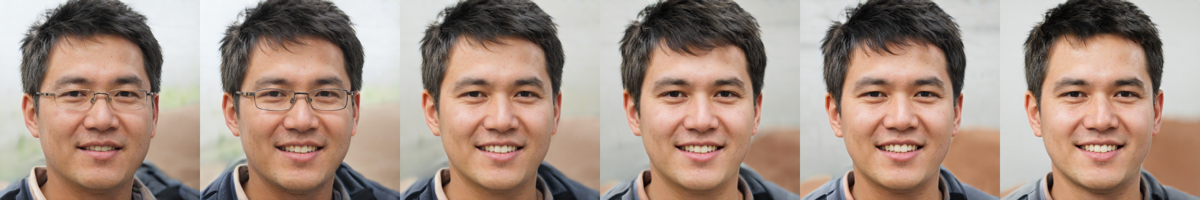

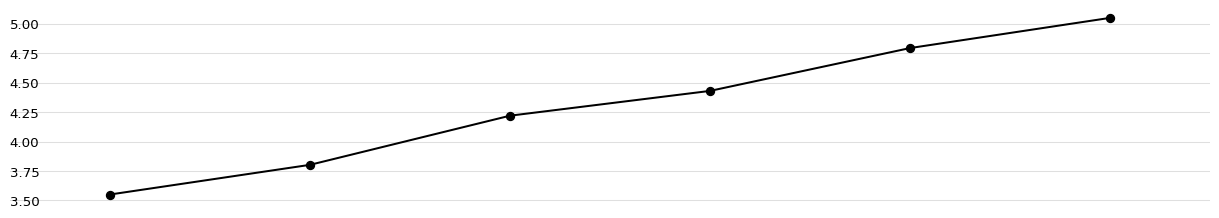

Saliency increase: 4.8829 → 6.0041 (122.96%)


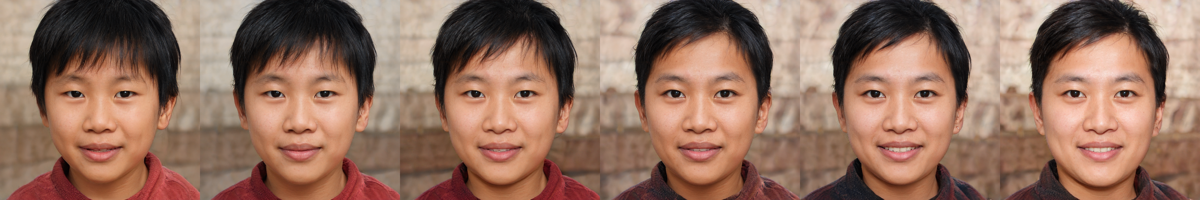

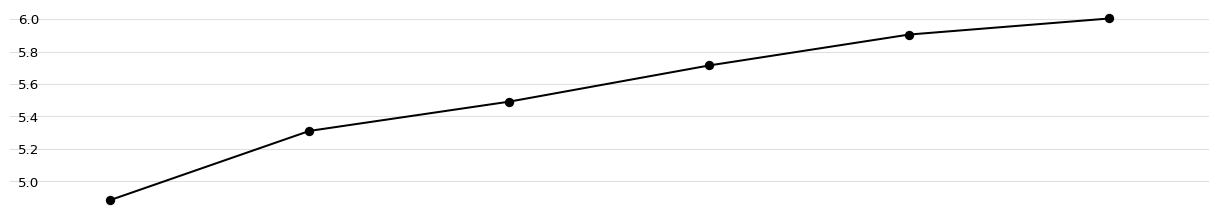

Saliency increase: 4.1627 → 5.1282 (123.19%)


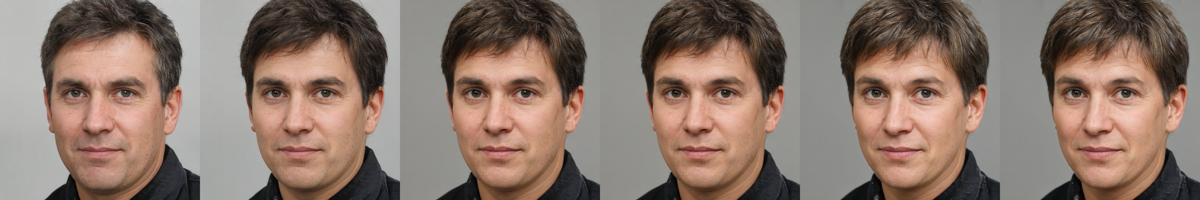

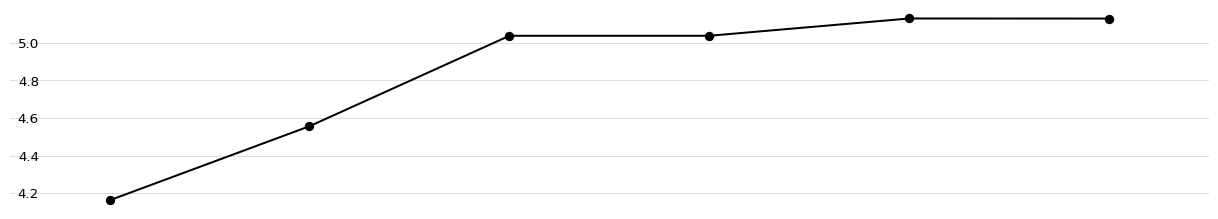

Saliency increase: 4.2452 → 5.1052 (120.26%)


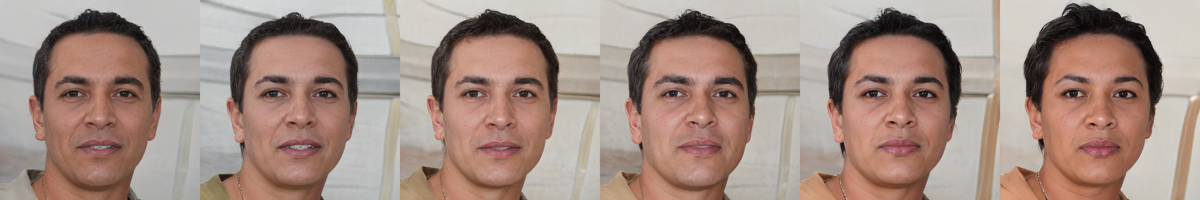

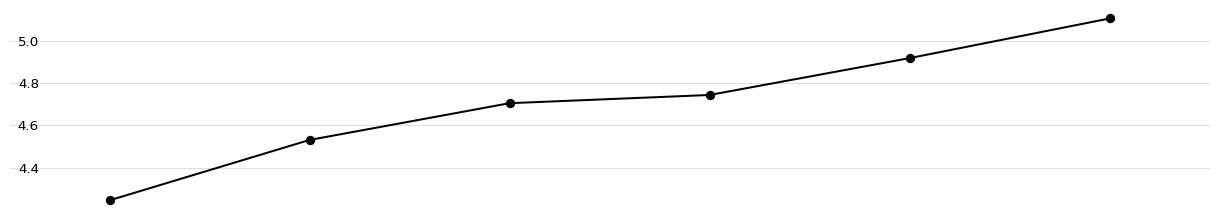

Saliency increase: 4.2101 → 5.5751 (132.42%)


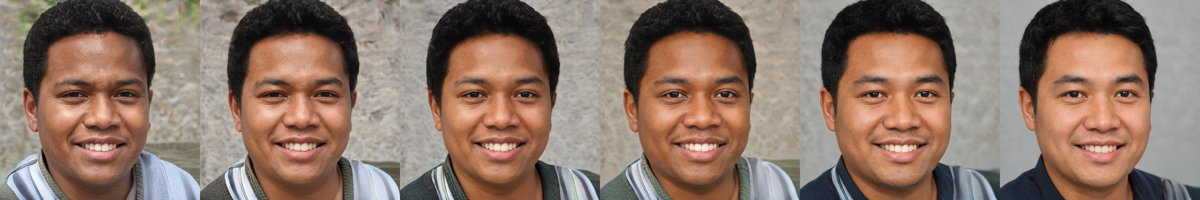

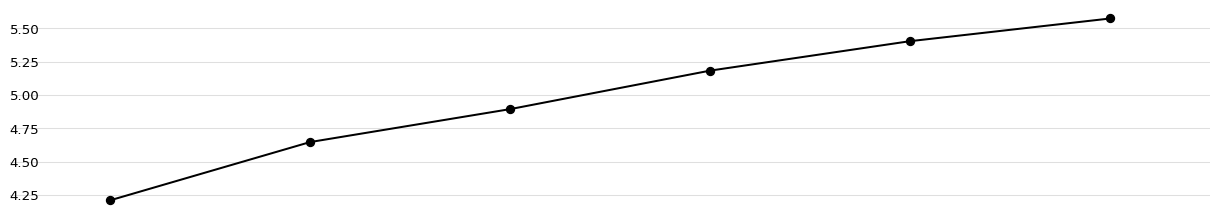

Saliency increase: 4.7844 → 5.5148 (115.27%)


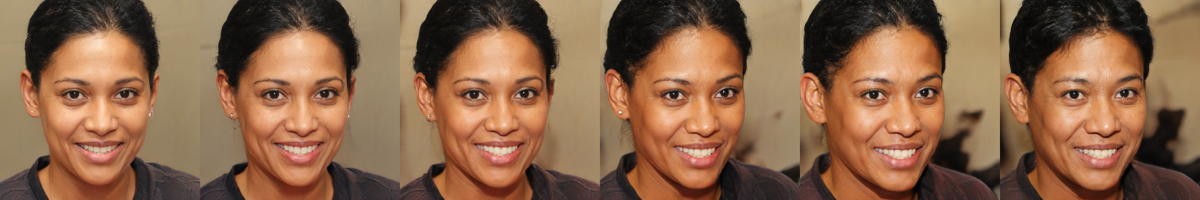

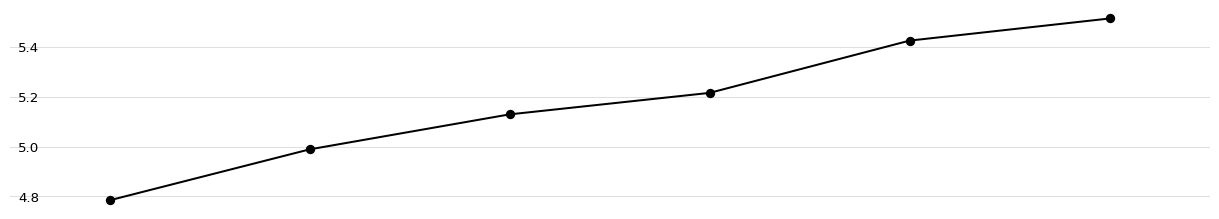

Saliency increase: 4.0503 → 5.4831 (135.37%)


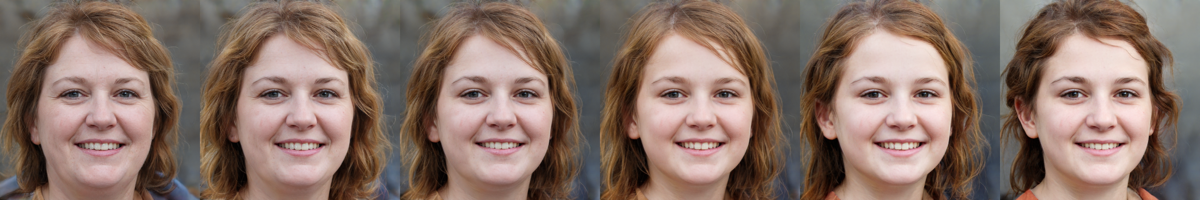

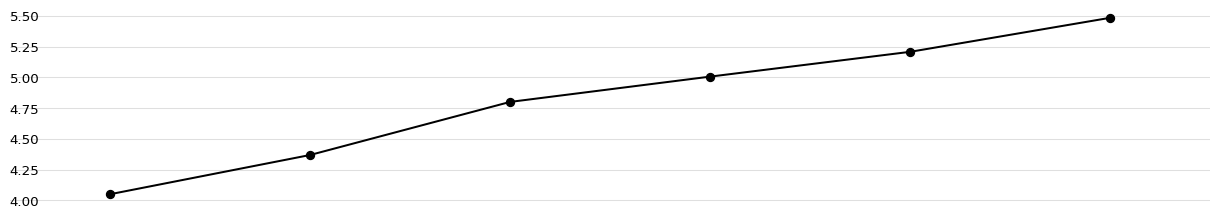

Saliency increase: 4.2863 → 5.1079 (119.17%)


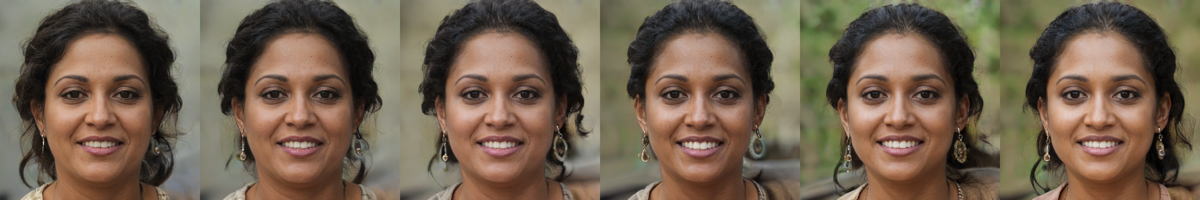

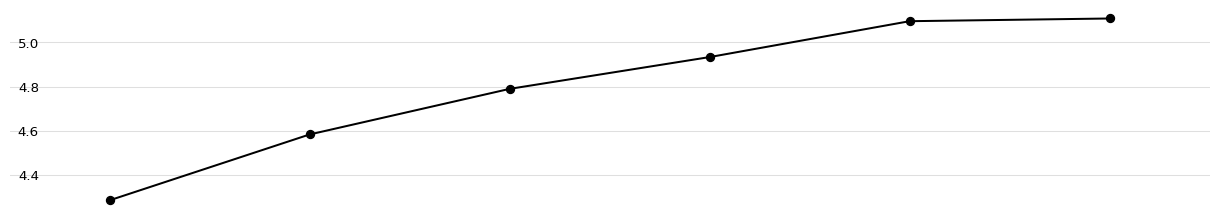

Saliency increase: 5.0172 → 6.1746 (123.07%)


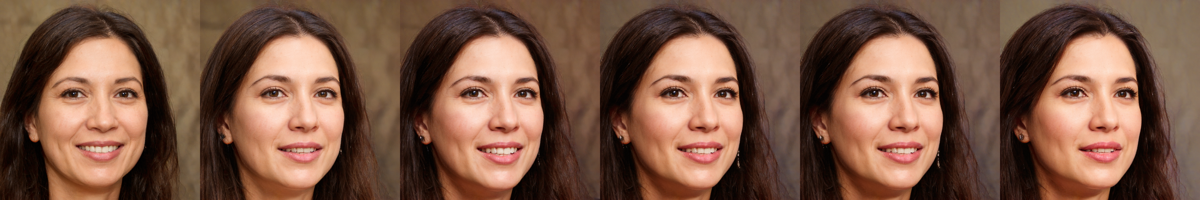

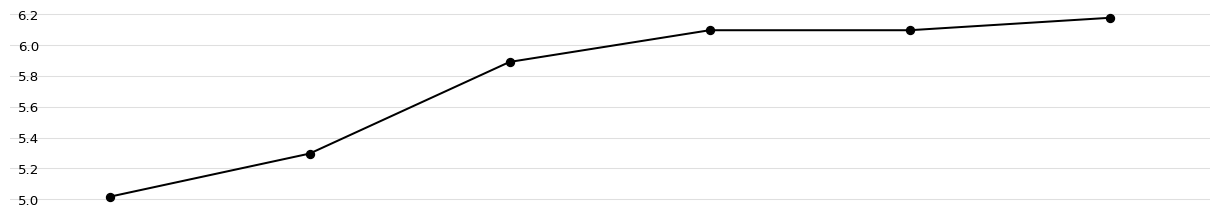

Saliency increase: 4.3722 → 5.6480 (129.18%)


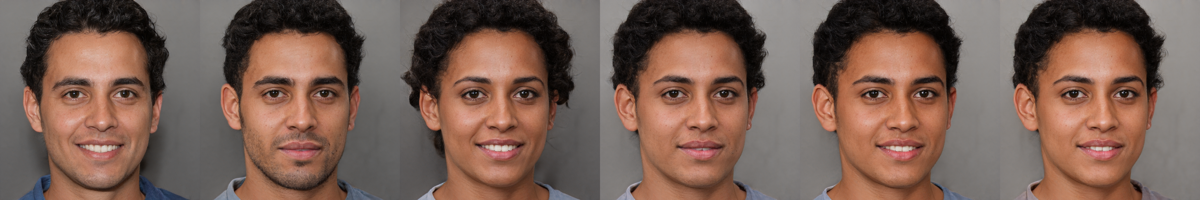

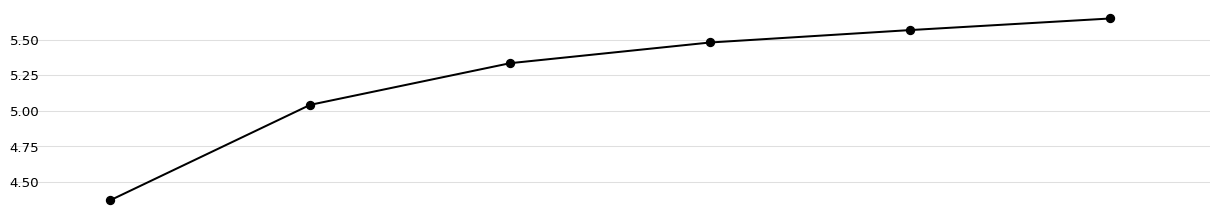

Saliency increase: 3.7050 → 5.3977 (145.69%)


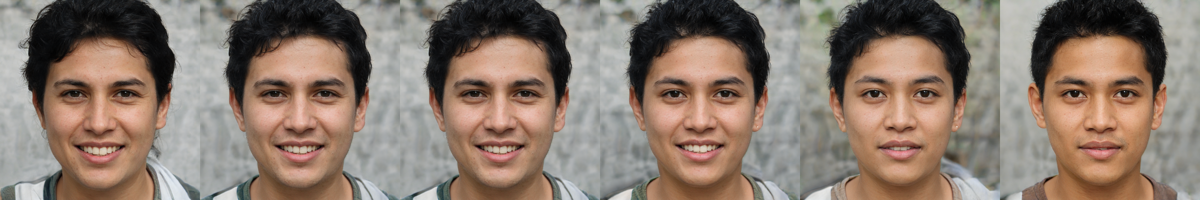

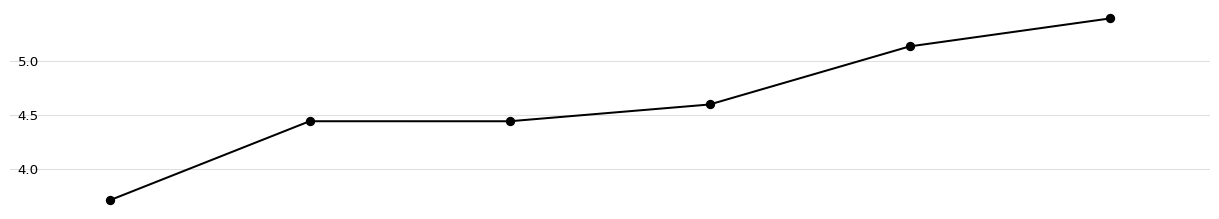

Saliency increase: 2.8133 → 4.4987 (159.91%)


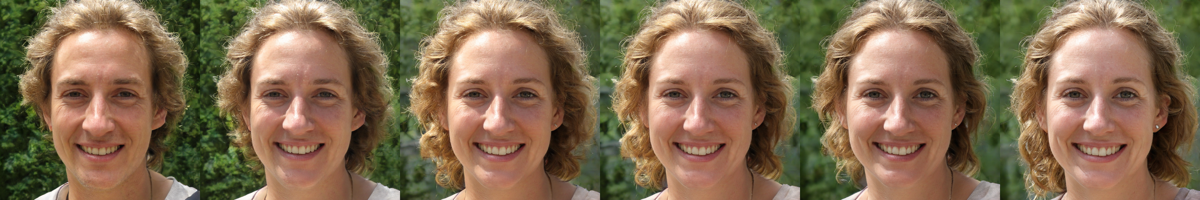

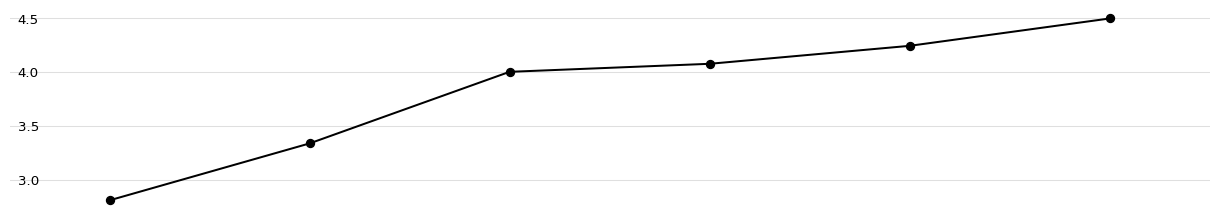

Saliency increase: 5.4336 → 6.0918 (112.12%)


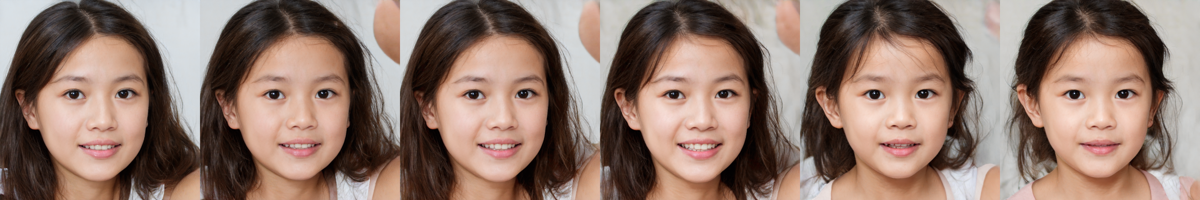

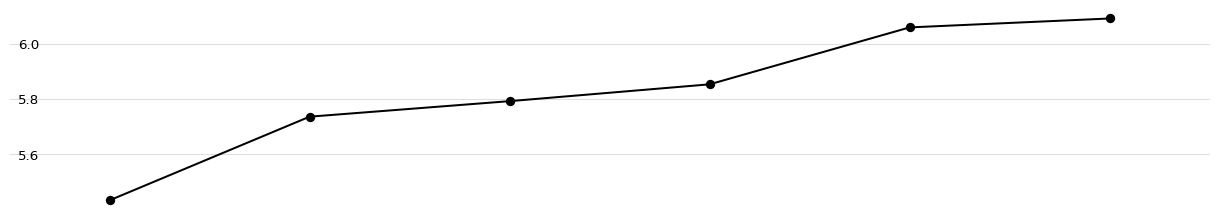

Saliency increase: 3.7001 → 5.1744 (139.85%)


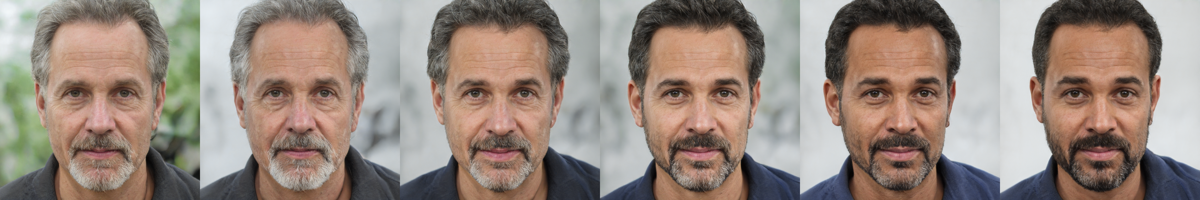

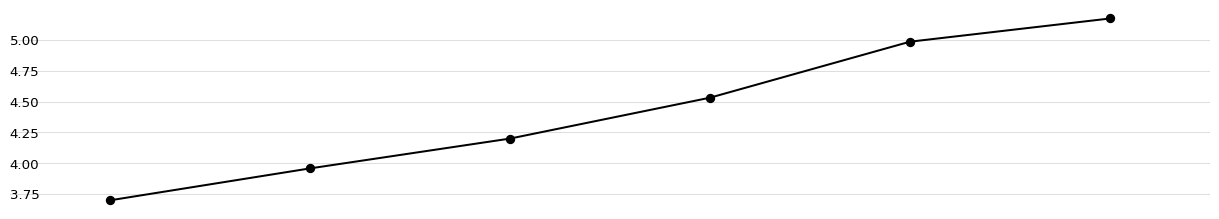

Saliency increase: 4.8834 → 6.0956 (124.82%)


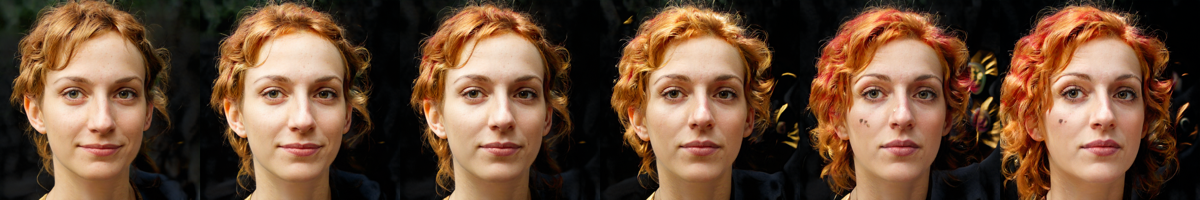

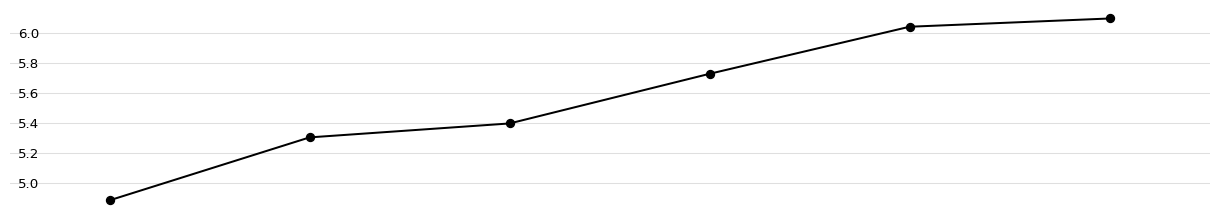

Saliency increase: 4.7067 → 5.8547 (124.39%)


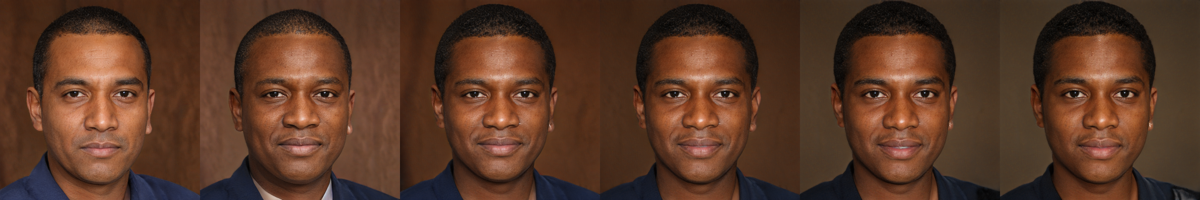

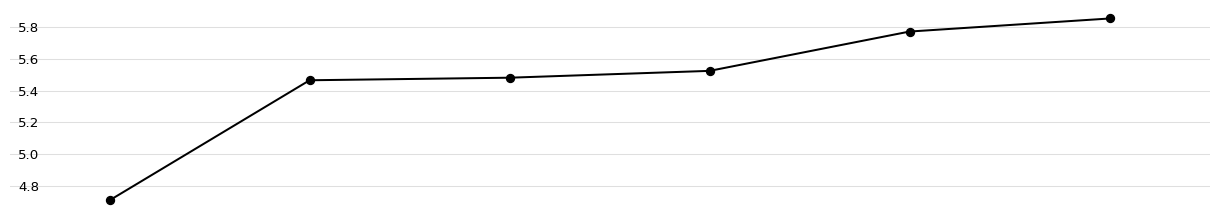

In [132]:
!mkdir -p images
display_size = 200

def plot_saliency_increase(scores):
  dpi = 96
  width = len(image_history) * display_size
  figsize = (width / dpi, 1 * display_size/dpi)
  fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
  ax.set_xticks([])
  ax.set_xlim(-0., len(range(len(scores))))
  ax.set_frame_on(False)
  ax.tick_params(axis="y", direction="in", pad=-22)
  ax.plot(np.arange(len(scores)) + 0.5, scores, marker="o", color="black")
  ax.grid(axis="y", color='grey')
  ax.tick_params(length=0, direction='out', color="black", width=1, grid_alpha=0.25)
  # ax.set_title("Predicted maximum saliency", **dict(fontname="Liberation Sans"))
  fig.tight_layout(pad=0.0)

for i, seed in enumerate(seeds_data):
  image, history = seeds_data[seed]
  image_history = [np.array(old_img) for score, old_img in history[:-1]] + [image]

  # Show and save the transition.
  transition = Image.fromarray(np.hstack(image_history), "RGB")
  transition.save("images/transition%i_full.png" % (i + 1))
  small_transition = transition.resize((int(display_size * len(image_history)), display_size))
  small_transition.save("images/transition%i.png" % (i + 1))
  
  # Make saliency plot.
  scores = [s for s, _ in history]
  print("Saliency increase: {:.4f} → {:.4f} ({:.2f}%)".format(
      scores[0], scores[-1], scores[-1] / scores[0] * 100))
  display(transition.resize((int(display_size * len(image_history)), display_size)))
  plot_saliency_increase(scores)
  plt.savefig("images/transition%i_plot.png" % (i + 1))
  plt.show()